In [1]:
%load_ext autoreload
%autoreload 2

import os 
os.chdir('/workspaces/anaconda/transformer_arithmetic')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from lib.config import config
from transformer_lens import HookedTransformer
from lib.train import init_model, evaluate
from lib.data import get_train_test_loaders, detect_carry
import torch as t

config['ckpt_name'] = 'ckpt_19750.pt'
config['out_dir'] = f'out/tiny_models/reverse-n_digit-5-n_layer-1-n_head-3'
config['resume'] = True
config['wandb_log'] = False
config['device'] = 'cuda:0'
config['num_test'] = 1000
config['use_hookedtransformer'] = True
config['use_saved_config'] = True
model, it, best_val_acc, ckpt, encode, decode, vocab_size = init_model(config)
model: HookedTransformer
model.eval()
print(it, config['n_digit'])
train_dataloader, test_dataloaders, test_train_dataloader = get_train_test_loaders(encode, config)
# test_dataloaders[0].dataset.prompt_pad_length = 30
test_dataloader = test_dataloaders[0]
evaluate(model, it, [test_dataloader], encode, decode, config=config, verbose=True)
tds = [d for d in test_dataloader.dataset]
test_dataset = test_dataloader.collate_fn(tds)
carries = t.tensor([sum([c[i]*2**i for i in range(len(c))]) for c in test_dataset['carries'].cpu().numpy()])
eq_pos = test_dataloader.dataset.prompt_pad_length - 1
pad_token_id = test_dataloader.dataset.pad_token_id


all the unique characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 96
Moving model to device:  cuda:0
19750 5


  0%|          | 0/1 [00:00<?, ?it/s]

inp: '##$538+64233=' out: '90056$' ans: '17746$'
inp: '##$6482+3439=' out: '19901$' ans: '1299$'
inp: '##$7102+3940=' out: '29901$' ans: '24011$'
inp: '##$83160+169=' out: '90048$' ans: '92338$'
inp: '##$78445+945=' out: '00097$' ans: '09397$'
inp: '#$81921+6885=' out: '60878$' ans: '60888$'
inp: '##$11437+992=' out: '90021$' ans: '92421$'
inp: '##$94403+601=' out: '49059$' ans: '40059$'
inp: '#$7979+87119=' out: '89079$' ans: '89059$'
inp: '##$84629+681=' out: '09058$' ans: '01358$'
inp: '#$59045+3005=' out: '05036$' ans: '05026$'
inp: '#$89912+1140=' out: '25009$' ans: '25019$'
inp: '###$1098+666=' out: '4999$' ans: '4671$'
inp: '##$3177+2827=' out: '49901$' ans: '4006$'
inp: '##$45590+638=' out: '80064$' ans: '82264$'
inp: '##$562+78519=' out: '98096$' ans: '18097$'
inp: '##$85492+639=' out: '19068$' ans: '13168$'
inp: '#$10032+7245=' out: '77471$' ans: '77271$'
inp: '###$6190+123=' out: '3909$' ans: '3136$'
inp: '##$99528+323=' out: '190001$' ans: '15899$'
inp: '##$514+69909=' out:

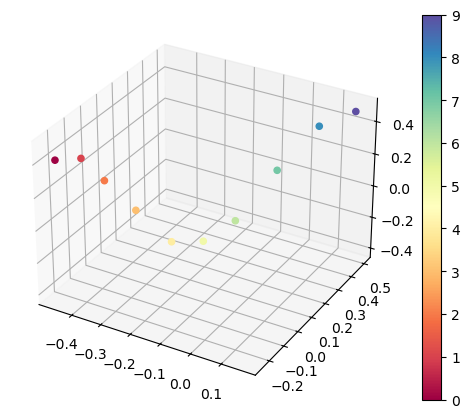

In [2]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=10)

# pca.fit(cache['resid_post', 0][:,13,:].cpu().numpy())
digit_list = []
for d in range(config['ary']):
    digit_list.append(encode(str(d))[0])
pca.fit(model.W_E[digit_list, :].detach().cpu().numpy().T)

ax = plt.figure(figsize=(7,5)).add_subplot(111, projection='3d')
m = ax.scatter(pca.components_[0], pca.components_[1], pca.components_[2], c=range(config['ary']), cmap='Spectral', alpha=1)
plt.colorbar(m, ax=ax)

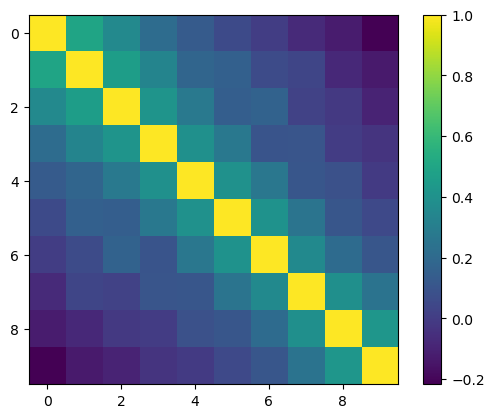

<BarContainer object of 10 artists>

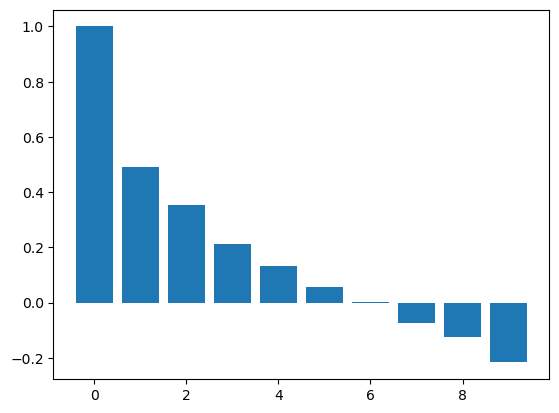

In [4]:
# each embedding should be nearly orthogonal to each other

embs = model.W_E[digit_list, :].detach()
embs /= embs.norm(dim=1, keepdim=True)
gram = t.einsum('ij,kj->ik', embs, embs).cpu().numpy()
plt.imshow(gram)
plt.colorbar()
plt.show()

plt.figure()
plt.bar(range(len(gram)), gram[0])

In [33]:
from tqdm import tqdm
from transformer_lens import ActivationCache
from matplotlib import pyplot as plt
import numpy as np
from lib.data import detect_carry

import torch as t

sorted_test_lines = []
for a in range(10000, 99999, 100):
    for b in range(10000, 99999, 1000):
        carries = detect_carry(a, b)[2]
        if sum(carries) == 2:
            sorted_test_lines.append([encode(f'${a}+{b}={a+b}'.rjust(19, '#'))])
sorted_test_lines = t.tensor(sorted_test_lines).squeeze(1)

print(sorted_test_lines.shape)

cache_dict = {}
with t.no_grad():
    for bid, _ in tqdm(enumerate(range(sorted_test_lines.shape[0] // config['eval_batch_size']+1))):
        test_input = sorted_test_lines[bid * config['eval_batch_size']:(bid + 1) * config['eval_batch_size']]
        logits, cache = model.run_with_cache(test_input, attention_mask=None, return_type='logits', pad_token_id=pad_token_id)
        cache.to('cpu')
        for key, value in cache.items():
            if key not in cache_dict:
                cache_dict[key] = [value]
            else:
                cache_dict[key] += [value]

for key, value in cache_dict.items():
    cache_dict[key] = t.cat(value, dim=0)
cache = ActivationCache(cache_dict, model)


torch.Size([23850, 19])


24it [00:02,  9.98it/s]


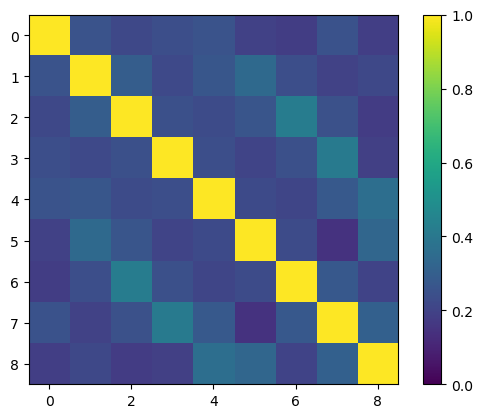

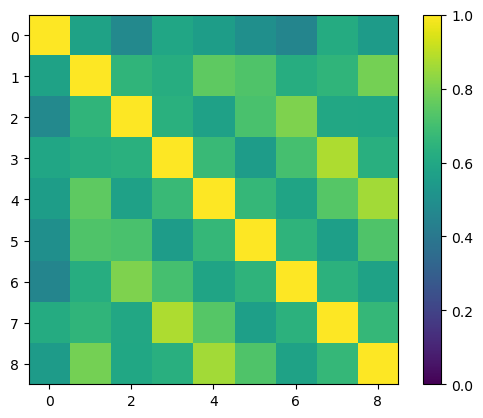

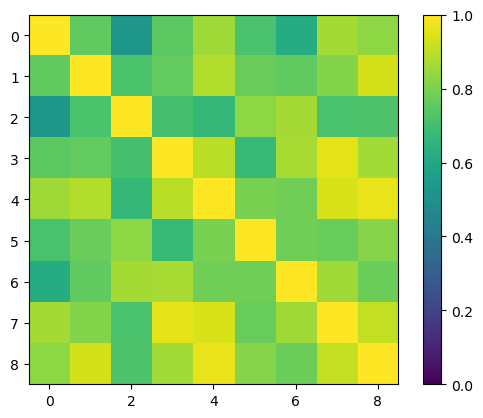

In [172]:
test_string = '$123456789123456789123456$'
test_line = t.tensor(encode((test_string * (256 // len(test_string))).ljust(256, '#')))

_, cache = model.run_with_cache(test_line.to(config['device']), remove_batch_dim=True, attention_mask=None, return_type='logits', pad_token_id=pad_token_id)
cache = cache.to('cpu')

# print(cache['pos_embed'].shape)
# fft = np.fft.rfftn(cache['pos_embed'].numpy(), axes=[0])
# plt.figure()
# plt.plot(np.abs(fft).mean(1))

# fft = np.fft.rfftn(cache['resid_post', 0].numpy(), axes=[0])
# plt.figure()
# plt.plot(np.abs(fft).mean(1))

# print(test_line[:-(256 % 19)].reshape(256 // 19, 19, -1)[:1])

for act in [cache['resid_pre', 0], cache['resid_mid', 0], cache['resid_post', 0]]:
    act = act[:-(256 % len(test_string))].numpy()
    # act = np.fft.fftn(act, axes=[0])
    act = act.reshape(256 // len(test_string), len(test_string), -1)
    act /= np.linalg.norm(act, axis=(1, 2), keepdims=True)
    gram = np.einsum('ilk,jlk->ij', act, act)
    # act = act.reshape(256 // 19, -1)[..., None]
    # D = np.linalg.norm(act - act.T, axis=1)

    plt.figure()
    plt.imshow(gram, vmax=1, vmin=0)
    plt.colorbar()


9


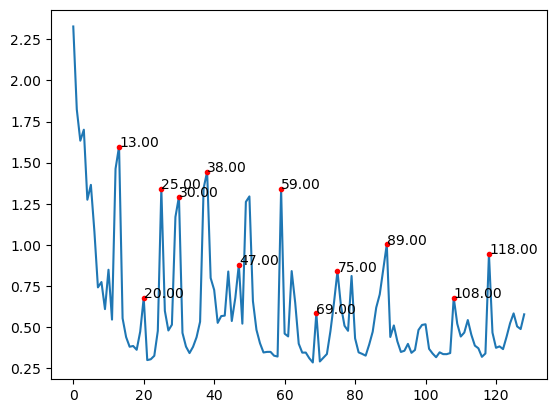

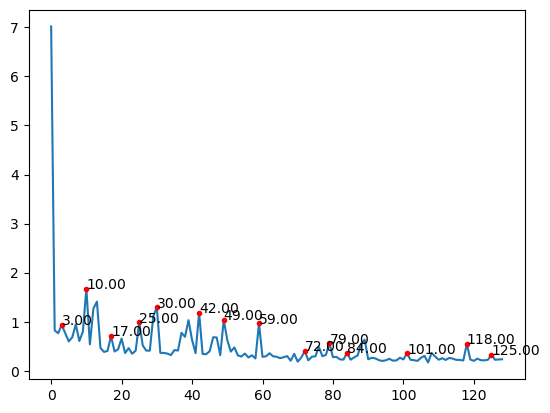

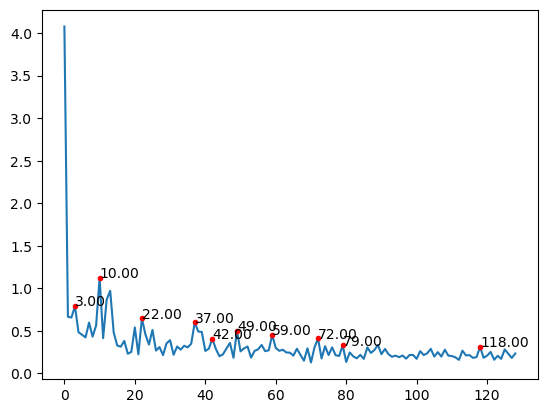

In [173]:
import numpy as np
import scipy
# position embedding PCA

print(256 // len(test_string))

for act in [cache['resid_pre', 0], cache['resid_mid', 0], cache['resid_post', 0]]:
    act = act.numpy()
    act /= np.linalg.norm(act, axis=(-1), keepdims=True)
    pca = PCA(n_components=20)
    pca.fit(act)
    # plt.figure(figsize=(10, 10)).add_subplot(111, projection='3d')
    # plt.plot(pca.components_[0], pca.components_[1], pca.components_[2])

    plt.figure()
    fft = np.fft.rfftn(act, axes=[0])
    fft_freqs = np.fft.rfftfreq(act.shape[0], d=1/act.shape[0])
    # Calculate the absolute value and the angle
    abs_fft = np.abs(fft).mean(1)
    angle_fft = np.angle(fft).mean(1)

    # Find the local maxima in the absolute value
    peaks, _ = scipy.signal.find_peaks(abs_fft, threshold=0.1, distance=5)

    # Plot the absolute value and the angle
    plt.plot(fft_freqs, abs_fft)
    # plt.plot(fft_freqs, angle_fft)

    # Mark the peaks
    plt.plot(fft_freqs[peaks], abs_fft[peaks], 'r.')

    # Annotate the peaks
    for peak in peaks:
        plt.annotate(f'{fft_freqs[peak]:.2f}', (fft_freqs[peak], abs_fft[peak]))
    # plt.figure()
    # plt.imshow(np.abs(fft))

    # f, axs = plt.subplots(10, 1, figsize=(10, 20))
    # fft = np.fft.rfftn(pca.components_.T, axes=[0])
    # for i in range(10):
    #     axs[i].plot(np.abs(fft)[:, i])

torch.Size([23850, 19, 19])
(11926, 19)
torch.Size([23850, 19, 19])
(11926, 19)
torch.Size([23850, 19, 19])
(11926, 19)
torch.Size([23850, 19, 19])
(11926, 19)
torch.Size([23850, 19, 19])
(11926, 19)


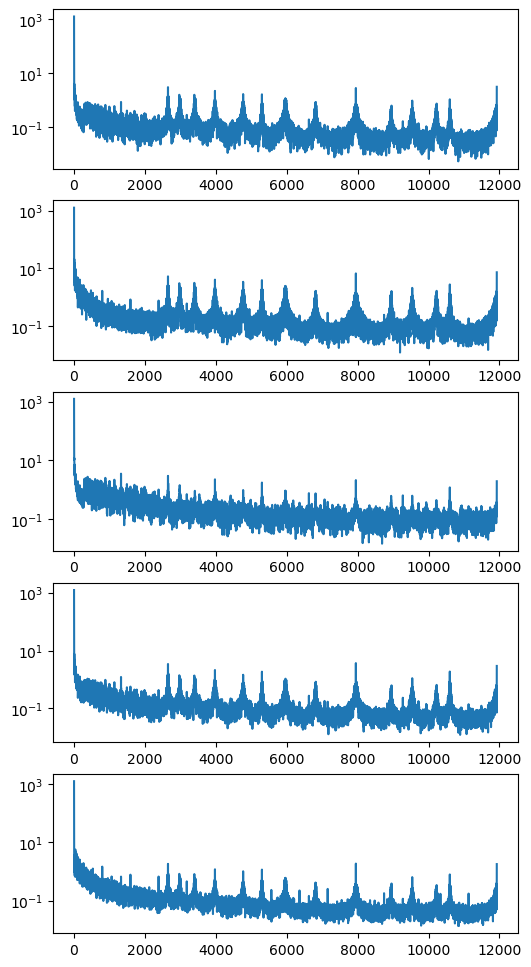

In [34]:
f, axs = plt.subplots(5, 1, figsize=(6, 12))
target_layer = 0
target_head = 2
for i, target_pos in enumerate(range(12, 17)):
    X = cache['v', target_layer][:, target_head]
    print(X.shape)
    X = X[:, target_pos].cpu().numpy()

    # X = X - X.mean(0)
    fft = np.fft.rfftn(X, axes=[0])
    print(fft.shape)
    axs[i].plot(np.abs(fft).mean(1))
    axs[i].set_yscale('log')

    # plt.figure()
    # axs[i].imshow(np.log(np.abs(fft)))